# Documentation for Hydra Multi-Asset Verification Test

## Model Description

The methodology for the tests is to create two universes - one for Hydra and one for Uniswap - to subsequently be able to represent sequences of actions on each side. As the Hydra system is unique in its design and has no counterpart yet for approprate comparisons the role of the benchmark will be fulfilled by assembling several Uniswaps together in a way that everything that can be done in Hydra can be accordingly reproduced. This allows next to compare the implications on both systems and ultimately assess the quantitative and qualitative differences of results and impacts on the Hydra system and its agents. 

This approach necessitates the definition and specification of two models:
   - 1 Hydra Omnipool model with one instance that is defined in line with the [Hydra Mathematical Specification](https://hackmd.io/M7OeWimITKGVxBDHGQa6gQ?view)
   - 1 Uniswap model with several instances that each are responsible for a particular mechanism
        - which of 1 instance is used for liquidity provision in asset $R_i$: this is modeled as a Uniswap of $R_i$ and $Q$
        - which of 1 instance is used for liquidity provision in asset $R_j$: this is modeled as a Uniswap of $R_j$ and $Q$
        - which of 1 instance is used for swaps between assets $R_i$ and $R_j$: this is modeled as a Uniswap of $R_i$ and $R_j$
        
![](https://i.imgur.com/yb6Zh3T.png)
        
## Test cases

A variety of testcases can be explored with this model resulting from a combination of the following parameters
   
   - Event: Add Liquidity, Remove Liquidity, Swap Asset, Swap Asset for Base
   - Asset: $R_i$, $R_j$, $R_k$, $Q$
   - Multiple Action Type: Alternating, $i$ only, $j$ only
   - Composite Action Type: Alternating, Trade Bias
   - Enable Symmetric Liquidity: True, False
    
In addition to these settings also a fee structure can be imposed:

   - Fixed Fee

## Test agents

The model specifies a number of eight agents that each have their local balances, can interact with the system and are modeled to be responsible for **one action only**. This allows to track for each testcase how the balances will develop and to show independently which events will trigger changes to local and global states. Most importantly directly and indirectly affected variables can be easily identified.

Two dataframes of agents are initialized identically for both the Uniswap and the Hydra world and then work their way through on each side according to the testcase. Afterwards the effects on both sides can be compared.

![](https://i.imgur.com/r9IAJMr.png)



## Composite Action Tests

Besides being able to test all mechanisms individually also compositions of actions can be performed. This means selecting and combining two from the above testcases and letting the respective agents take the actions repeadetly. A composition action test therefore is defined as two actions which each can be a combination of *event* and *asset* selected from the list of testcases above, for example:
- Add liquidity in $R_i$ and Add liquidity in $R_j$
- Add liquidity in $R_i$ and Swap $R_i$ for $Q$
- Remove liquidity in $R_j$ and Swap $R_i$ for $Q$
- ...

In total there would be 28 composit pairs which can be derived from this decision tree:
selecting any one of the four primitive mechanisms of: **trade in/out** or **add/remove liquidity** of some given asset and then the subsequent action could be the three remaining mechanisms of the same asset or doing anyone of the four mechanisms in another asset.  

These basic combinations can be explored before further proceeding with
- trade sizes,
- trade frequencies,
- randomization,...



# Testcase in this notebook


This notebook documents the results of the following experiment:
- **Action 1**: One agent adds liquidity in XX
- **Action 2**: Another agent trades XX for XX.

which is a reslt of the following settings:

- exo_trade = ['test_q_for_r'] # agent 0
- exo_liq = ['test_add'] # agent 3
- exo_asset = ['alternating']
- exo_composite = ['alternating'] 

## Introduction to Uniswap
>Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://uniswap.io/

There are basically eight ways (_mechanisms_) in which an agent can interact with an instance of Uniswap (https://github.com/Uniswap/uniswap-v1/blob/master/contracts/uniswap_exchange.vy):
1. `addLiquidity`: deposit ETH and tokens in the liquidity pool; mint UNI tokens - "shares" of that Uniswap instance - in exchange;
1. `removeLiquidity`: burn UNI tokens; withdraw a proportional amount of ETH and tokens in exchange;
1. `ethToTokenInput`: user specifies an exact amount of ETH they send; receives corresponding amount of tokens
1. `ethToTokenOutput`: user sends some ETH and specifies an exact amount of tokens they want to buy; Uniswap refunds ETH sent in excess
1. `tokenToEthInput`: user specifies an exact amount of tokens they send; receives corresponding amount of ETH
1. `tokenToEthOutput`: user specifies an exact amount of ETH they want to buy; Uniswap takes the corresponding amount of tokens from the user account
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" (effectively a `tokenToEthInput` in instance A combined with a `ethToTokenInput` in instance B)
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Uniswap takes the corresponding amount of "token A" from the user account (effectively a `ethToTokenOutput` in instance B combined with a `tokenToEthOutput` in instance A)

## Limitations and simplifications of this model
* When triggering mechanisms, Uniswap users may include conditions they would like to apply to the transaction. For example, they could define a minimum amount of UNI tokens they wish to receive as a result of adding liquidity to the pool; or the maximum number of tokens they are willing to pay for the amount of ETH requested in a `tokenToEthOutput` operation; or a deadline after which the transaction should not be processed. **This simplified model does not account for this kind conditioning.**

* The `ethToTokenOutput`, `tokenToEthOutput` mechanisms are not implemented. **All swaps are treated as of the "input defined" type.**

* The `tokenToToken` mechanism are not implemented, as they are merely a `tokenToEth` in the context of a single Uniswap instance.

* **User _behavior_ has not been modeled**. User _actions_ are derived from the history of events of the Uniswap instance being analyzed.

## Introduction to Hydra
>Hydra is an automated market maker that generalizes the concept of Uniswap and Balancer to a) an arbitrary number of dimensions and b) a variant weight distaribution of assets in the pool that changes in accordance with action sequences in the pool. Anyone can become a liquidity provider, and invest in the 'Omnipool'. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://hydradx.io/

There is a predefined set of (_mechanisms_) in which an agent can interact with an the Hydra Protocol :
1. `addLiquidity`: deposit a risk asset in the omnipool; mint HDX tokens - "shares" of this risk asset - in exchange;
1. `removeLiquidity`: burn HDX tokens; withdraw a proportional amount of the risk asset in exchange;
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" 
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Hydra takes the corresponding amount of "token A" from the user account 



## Model File structure

The folder **model** contains:

 - a file config.py: 

    This file configures the simulation experiments by setting the number of monte carlo runs, the number of timesteps for the simulation and the simulation parameters. It also aggregates the partial states and the initial state variables.
    
    The purpose of this file is to *configure and initialize* the experiment.
    
    
 - a file partial_state_update_block.py

    This file defines each partial state update block individually. This feature allows cadCAD to divide each simulation timestep into several 'blocks' where different state variables are mutated conditioned upon the policy input.
    
    In the current setting 
    - the first block maps the user action to the appropriate mechanism in the uniswap world
    - the second block maps the user action to the appropriate mechanism in the hydra world
    - the third block resolves the quantities of HDX and weights in the hydra world
    - the forth block calculates the metrics: the swap prices in the uniswap world and the pool prices in the hydra world

    This file corresponds to the system specification diagram, where each column is one partial state update block 
    
    The purpose of this file is to *define* the sequence and details of state updates for each simulation timestep. The relevant mechanisms are imported from the files in the **parts** folder
    
    
 - a file plot_utils.py

    This file defines all plot functions that can be called in the jupyter notebook to visualize the results. In general there are three types of plots:
    - plots related to the uniswap world (do not contain the word 'hydra')
    - plots related to the hydra world (contain the word 'hydra')
    - general plots applicable to both worlds (f.e Impermanent Loss)

    It also can be distinguished between plots related to global system variables and local agent variables:
    - global variables (do not contain the word 'agent')
    - local variables (contain the word 'agent')

    The purpose of this file is to *define* the way how particular properties can be plotted over time.
    

 - a file run.py

    This file *defines* the run and postprocessing methods and is used to execute the simulation run:
    - run() is used to execute the simulation and create a dataframe
    - postprocessing is used to extract relevant metrics from the simulation output in the dataframe

     The purpose of this file is to *execute* the simulation and *create* metrics.
     
     
 - a file state_variables.py

    This file *sets* the number of agents and *defines* the local (agent-level) state variables, *sets* the number of assets and *defines* the global (system-state) variables of the system, *computes* the prices of the assets and *defines* the initial state object
    - the agent states describe their holdings of assets that agents have contributed to the pool or still hold outside as well as their quantities of shares they received for their contribution
    - the global states describe the quantities of assets in the system
    - price variables are computed from the states both in the uniswap and hydra world
    - the initial state object consists of 
        - two agent dataframes, one for each world respectively
        - two sets of global variables, one for each world respectively
        - prices for each world (? is pool = prices ?)

    The purpose of this file is to *define* the global and local states of the system.
    
    
 - a file sys_params.py

    This file *contains* the system parameters and allows to select items from a list for them. Following parameters can be defined:
    - trade action type
    - liquidity action type
    - multiple asset action type
    - composite action type
    - liquidity add type (symmetry)

    In addition the following is set
    - initial values for assets 
    - hard coded fee value
    - choice of the system parameters from the list above
    

 - a folder **parts** which itself contains general files relevant for both instances, files related specifically to Uniswap and files related specifically to Hydra 
      - [action.py](model/parts/action.py)
       This is an action dictionary which drives the model. As there are no behavioral assumptions in the model yet, currently actions are prescribed actions in testing mode derived from events. However, action schema respects https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange as much as possible, allowing for future analysis against uniswap transaction datasets.
        This file contains a function called 'actionDecoder' which takes its inputs from the file sys_params.py and maps those encoded events to agent actions. At first an arbitrary action dictionary is defined which then is adapted according to the choices of system parameters. In particular relevant are the parameter definitions of the asset, the composite and whether there is a trade or liquidity event defined.
        
    - [uniswap.py](model/parts/uniswap.py)
     Reads in action output and directs the action to the appropriate Uniswap mechanism for each corresponding Uniswap instance. Currently there are two instances in place, namely the R_i<>Q pair and the R_j<>Q pair. Both instances have their respective requisite state variables: UNI_Qx, UNI_Rx, and UNI_Sx.

    - [utils.py](model/parts/utils.py)
    Computes the state update for each Uniswap state variable and outputs the updated global state variables.
        
     - [agent_utils.py](model/parts/agent_utils.py)
     Computes the corresponding agent local state for each Uniswap agent resolving their action and outputs the updates local state variables.

      -  [hydra.py](model/prts/hydra.py)
     Reads in action output and directs the action to the appropriate Hydra mechanism for each state variable: Q, Sq, and pool.
    
      - [hydra_utils.py](model/parts/hydra_utils.py)
     Computes the state update for each Hydra state variable

    -  [asset_utils.py](model/parts/asset_utils.py)
     Computes the state update for each Reserve Asset in a Hydra Omnipool

    -  [hydra_agent_utils_class.py](model/parts/hydra_agent_utils_class.py)
     Computes the corresponding agent local state for each Hydra agent resolving their action and outputs the updates local state variables.
     
     #### The interrelations between the files are shown here:
     
    ![](https://i.imgur.com/mNhfQE4.png)



## Run Model

The following command lines import all packages, experiments and run the model 

This is the execution of cadcad. This writes the config object, does the execution and returns the rdf - which is a data object that shows the rows and columns of results in a dataframe

Here is one additional option as well. The postprocessing causes the index of the results to be every forth because of the cadcad architecture where the partial state updates are the substeps. With this option selected we see only the end of each timestep - the last substep. Therefore only final results are shown. To get a line for each substep the postprocessing needs to be deactivated. 

In [1]:
# Dependences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Experiments
from model import run
from model.parts.utils import *
from model.plot_utils import *

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

df = run.run()
rdf = run.postprocessing(df)
# rdf = df # debugging substeps



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (12, 16, 1, 20)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
{'fee_numerator': 1000, 'fee_denominator': 1000, 'exo_trade': 'pass', 'exo_liq': 'pass', 'ENABLE_SYMMETRIC_LIQ': False, 'exo_asset': 'alternating', 'exo_composite': 'alternating', 'Ki': 10000000, 'ACTION_LIST': ['test_add', 'test_r_for_q', 'test_q_for_r', 'test_r_for_r', 'test_remove'], 'CHANGE_LOG': '4-01-21', 'a': 1.0, 'ENABLE_BALANCER_PRICING': True, 'exo_trade_size': 'fix_size', 'mu': 1000, 'sigma': 500, 'exo_random_sequence': 'on'}
0 {'q_sold': 0, 'ri_sold': 1000.0, 'ri_deposit': 0, 'q_deposit': 0, 'Si_burn': 0, 'action_id

## Interpretation of Results

### Creation of Results

Before moving to the interpretation and analysis we first create and prepare the results: sometimes just to see whether the experiment is running corectly and sometimes to see into the results for analysis

The following command lines creates views based on the simulation results.

- the `model_history`, counting for the i-th base asset, the risk asset and the shares of the risk asset respectively.
- the `uniswap_j`, counting for the j-th base asset, the risk asset and the shares of the risk asset respectively.,
- the `uniswap_ij` counting for the i-j asset, the risk asset and the shares of the risk asset respectively, and
- `hydra`, counting the base asset amount in the pool, the total base asset supply and the shares of the base asset respectively.



In [2]:
model_history = rdf[['UNI_Qi', 'UNI_Ri', 'UNI_Si']]
model_history.columns = ['model_UNI_Qi', 'model_UNI_Ri', 'model_UNI_Si']

uniswap_j = rdf[['UNI_Qj', 'UNI_Rj', 'UNI_Sj']]
uniswap_j.columns = ['UNI_Qj', 'UNI_Rj', 'UNI_Sj']

uniswap_ij = rdf[['UNI_ij', 'UNI_ji', 'UNI_Sij']]
uniswap_ij.columns = ['UNI_ij', 'UNI_ji', 'UNI_Sij']

hydra = rdf[['Q', 'H', 'Sq']]
hydra.columns = ['Hydra_Q', 'Hydra_H', 'Hydra_Sq']

### Risk assets in the Omnipool - the `pool` variable 

The `pool` variable is the risk-asset side of the Omnipool in the Hydra world.

For each asset in the Omnipool this variable tracks the following quantities:

- $R$ (asset quantity),
- $S$ (share quantity),
- $W$ (weight quantity = share quantity),
- $P$ (price) and 
- $dP$ (change in price).

To locate specific values in the `pool` dataframe 
- `first_valid_index()`
- `first_valid_index()*x`
- `last_valid_index()`

can be used for any integer value $x$.

In [3]:
print(rdf.pool[rdf.first_valid_index()])

<class 'model.parts.asset_utils.Asset'>: {'pool': {'i': {'R': 2056.715946521992, 'S': 10000, 'W': 12403.268445085316, 'P': 972.4240254868927, 'dP': 0}, 'j': {'R': 5161, 'S': 10000, 'W': 7596.731554914684, 'P': 387.5217981011432}, 'k': {'R': 4161, 'S': 10000, 'W': 10000, 'P': 480.6536890170632}}}


In [4]:
rdf.pool[rdf.first_valid_index()].pool

{'i': {'R': 2056.715946521992,
  'S': 10000,
  'W': 12403.268445085316,
  'P': 972.4240254868927,
  'dP': 0},
 'j': {'R': 5161, 'S': 10000, 'W': 7596.731554914684, 'P': 387.5217981011432},
 'k': {'R': 4161, 'S': 10000, 'W': 10000, 'P': 480.6536890170632}}

In [5]:
rdf.pool[rdf.first_valid_index()*10].pool

{'i': {'R': 12052.240256915793,
  'S': 57105.00637172317,
  'W': 109165.77506780683,
  'P': 11576.8087644201,
  'dP': 0},
 'j': {'R': 43.30514535692032,
  'S': 10000,
  'W': 3584.7075361213774,
  'P': 564212.8264242742},
 'k': {'R': 4161, 'S': 10000, 'W': 10000, 'P': 5871.982326494123}}

In [6]:
rdf.pool[rdf.last_valid_index()].pool

{'i': {'R': 11856.525643809578,
  'S': 57105.00637172317,
  'W': 2387763.6956181014,
  'P': 425047.7242965472,
  'dP': 0},
 'j': {'R': 19464.79549245557,
  'S': 10000,
  'W': -86487.6802678412,
  'P': 45338.913738353855},
 'k': {'R': 4161, 'S': 10000, 'W': 10000, 'P': 212091.48852851285}}

### Representing results in table form

The simulation results and variable quantities can be shown in table form where

- `head(n)`
- `tail(n)`

can be used to target the $n$ specific entries.

##### The columns show:
##### for the uniswap universe
- `UNI_Qi`...the quantity of the i-th assets base
- `UNI_Ri`...the quantity of the i-th assets risk
- `UNI_Si`...the quantity of the i-th assets shares
- `UNI_Qj`...the quantity of the j-th assets base
- `UNI_Rj`...the quantity of the j-th assets risk
- `UNI_Sj`...the quantity of the j-th assets shares
- `uni_agents`...the definition of the actions of the uniswap agents
- `UNI_P_RQi`...the price of the i-th risk asset in terms of Q
- `UNI_P_RQj`...the price of the j-th risk asset in terms of Q

##### for the hydra universe
- `pool`...the definition of the pool variable
- `Q`...the quantity of the base asset in the hydra pool
- `H`...the total quantity of the base asset in the hydra system
- `Wq`...total quantity of weigths of the base asset
- `Sq`...total quantity of shares of the base asset
- `hydra_agents`...the definition of the actions of the hydra agents

##### simulation parameters
- `simulation`...simulation number
- `subset`...subset number
- `run`...run number
- `substep`...substep number
- `timestep`...timestep of simulation

Notice, that due to postprocessing of the simulation results this table always shows the forth substep of each timestep only.

In [7]:
rdf.head(5)

,UNI_Qi,UNI_Ri,UNI_Si,UNI_Qj,UNI_Rj,UNI_Sj,UNI_ij,UNI_ji,UNI_Sij,uni_agents,...,H,Wq,Sq,hydra_agents,C,simulation,subset,run,substep,timestep
4,2000000,2551,10000,2000000,4161,10000,2057,5161,10614711,m r_i_out r_i_in h q_i s_i ...,...,4000000.00,20000.00,20000.00,m r_i_out r_i_in h q_i s_i ...,1000000000000.00,0,0,1,4,1
8,2000000,2551,10000,2000000,4161,10000,3057,3473,10614711,m r_i_out r_i_in h q_i s_i ...,...,52621201.27,20000.00,263106.01,m r_i_out r_i_in h q_i s_i ...,25310600637172.32,0,0,1,4,2
12,2000000,52551,206001,2000000,4161,10000,3057,3473,10614711,m r_i_out r_i_in h q_i s_i ...,...,62228352.73,68035.76,263106.01,m r_i_out r_i_in h q_i s_i ...,25310600637172.32,0,0,1,4,3
16,2000000,52551,206001,2000000,4161,10000,4057,2617,10614711,m r_i_out r_i_in h q_i s_i ...,...,95234937.93,116549.34,263106.01,m r_i_out r_i_in h q_i s_i ...,25310600637172.32,0,0,1,4,4
20,2000000,52551,206001,2000000,4161,10000,2936,3617,10614711,m r_i_out r_i_in h q_i s_i ...,...,152100800.62,165340.58,263106.01,m r_i_out r_i_in h q_i s_i ...,25310600637172.32,0,0,1,4,5


In [8]:
rdf.tail()

,UNI_Qi,UNI_Ri,UNI_Si,UNI_Qj,UNI_Rj,UNI_Sj,UNI_ij,UNI_ji,UNI_Sij,uni_agents,...,H,Wq,Sq,hydra_agents,C,simulation,subset,run,substep,timestep
32,2000000,52551,206001,2000000,4161,10000,4301,2471,10614711,m r_i_out r_i_in h q_i s_i ...,...,312663693.81,253676.11,263106.01,m r_i_out r_i_in h q_i s_i ...,25310600637172.32,0,0,1,4,8
36,2000000,52551,206001,2000000,4161,10000,3062,3471,10614711,m r_i_out r_i_in h q_i s_i ...,...,288962935.97,244333.18,263106.01,m r_i_out r_i_in h q_i s_i ...,25310600637172.32,0,0,1,4,9
40,2000000,52551,206001,2000000,4161,10000,4062,2617,10614711,m r_i_out r_i_in h q_i s_i ...,...,-189932549.19,62317.01,67105.01,m r_i_out r_i_in h q_i s_i ...,5710500637172.32,0,0,1,4,10
44,2000000,2552,10000,2000000,4161,10000,4062,2617,10614711,m r_i_out r_i_in h q_i s_i ...,...,5767086703.70,2500389.13,67105.01,m r_i_out r_i_in h q_i s_i ...,5710500637172.32,0,0,1,4,11
48,2000000,2552,10000,2000000,4161,10000,5062,2101,10614711,m r_i_out r_i_in h q_i s_i ...,...,-18697341930.55,2250842.54,67105.01,m r_i_out r_i_in h q_i s_i ...,5710500637172.32,0,0,1,4,12


# The pools and global states

## Global State variables for the Uniswap world
## i - Q instance
### Quantities of i-th risk asset, the Q asset and the i-asset shares

The following command lines **create three plots** that show: (for the i-th asset)
- on the left: the quantity of base asset `model_UNI_Qi` 
- center: the quantity of risk asset `model_UNI_Ri` 
- on the right: the quantity of shares `model_UNI_Si`
over all simulation steps

To show other assets the suffix of these commands can be replaced by f.e. `Qj` instead of `Qi`

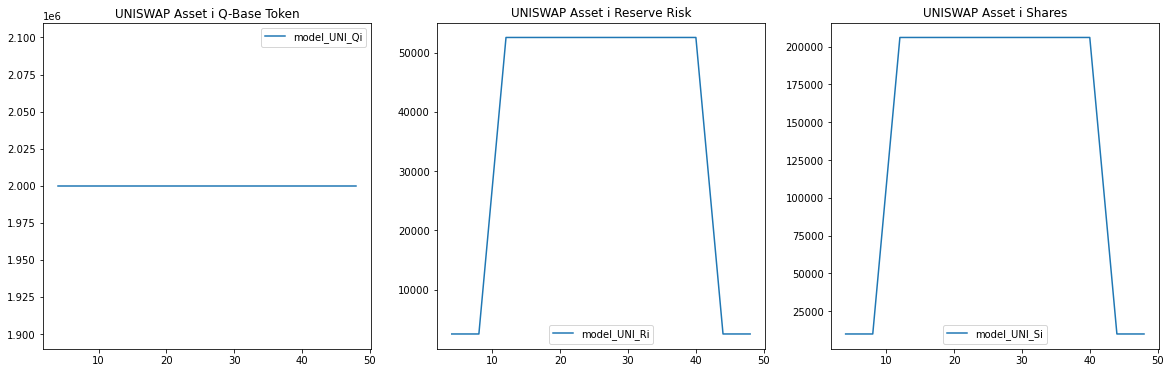

In [9]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Qi'])
plt.title('UNISWAP Asset i Q-Base Token')

ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Ri'])
plt.title('UNISWAP Asset i Reserve Risk')

ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Si'])
plt.title('UNISWAP Asset i Shares')
plt.show()

### Prices of the i-th asset

The following command line creates a plot of the prices: (for the i-th asset)
- the swap price of the risk asset 
- the pool ratio price of the risk asset

Comparison of both plots shows the effects of fees.

For experiments where the price of the asset is affected - for example when it is traded - we expect this price either to rise or fall accordingly. For liquidity adds this price should remain unchanged.

To show other assets the suffix of these commands can be replaced by f.e. `Qj` instead of `Qi`

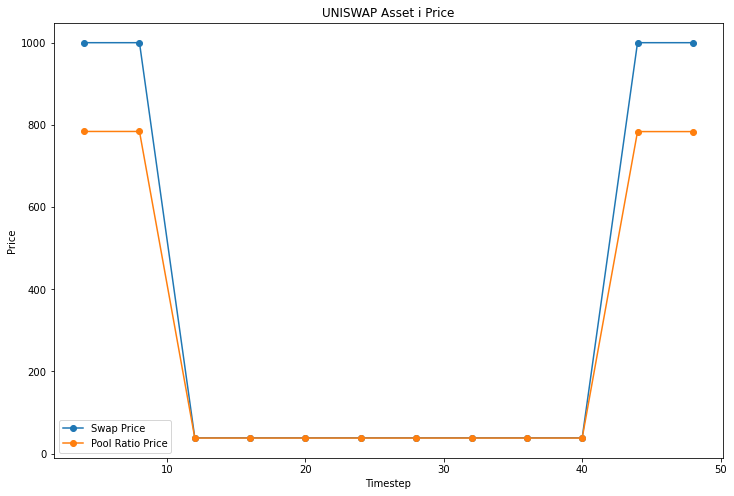

In [10]:
price_plot(rdf,'UNISWAP Asset i Price', 'UNI_P_RQi', 'UNI_Ri', 'UNI_Qi')

## j - Q instance
### Quantities of j-th risk asset, the Q asset and the j-asset shares


The following command lines create three plots that show: (for the j-th asset)
- on the left: the quantity of base asset `UNI_Qj` 
- center: the quantity of risk asset `UNI_Rj`
- on the right: the quantity of shares `UNI_Sj`

over the simulation steps

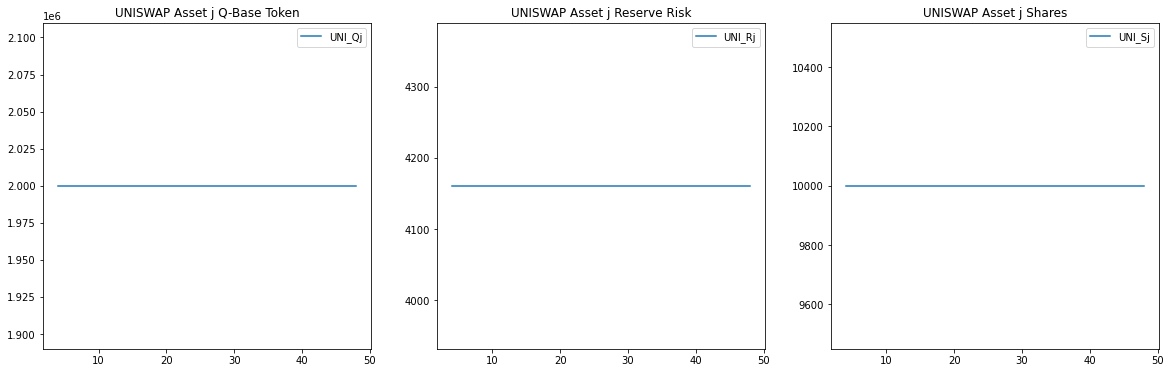

In [11]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Qj'])
plt.title('UNISWAP Asset j Q-Base Token')

ax = plt.subplot(132)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Rj'])
plt.title('UNISWAP Asset j Reserve Risk')

ax = plt.subplot(133)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Sj'])
plt.title('UNISWAP Asset j Shares')
plt.show()

### Prices of the j-th asset

The following command line creates a plot of the prices: (for the j-th asset)
- the swap price of the risk asset 
- the pool ratio price of the risk asset

Comparison of both plots shows the effects of fees.

For experiments where the price of the asset is affected - for example when it is traded - we expect this price either to rise or fall accordingly. For liquidity adds this price should remain unchanged.

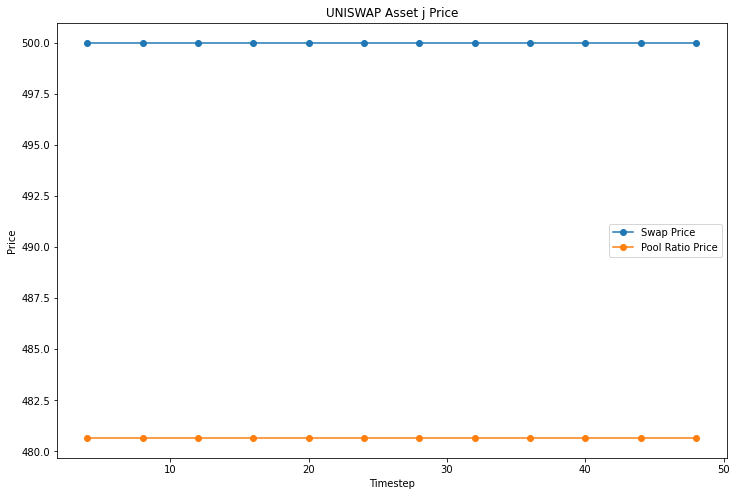

In [12]:
price_plot(rdf,'UNISWAP Asset j Price', 'UNI_P_RQj', 'UNI_Rj', 'UNI_Qj')

## i-j instance
### Quantities of i-th risk asset, the j-th risk asset and the i-j-asset shares


The following command lines create three plots that show: (for the j-th asset)
- on the left: the quantity of the i-th asset `UNI_ij` 
- center: the quantity of the j-th asset `UNI_ji`
- on the right: the quantity of i-j-shares `UNI_Sij`

over the simulation steps

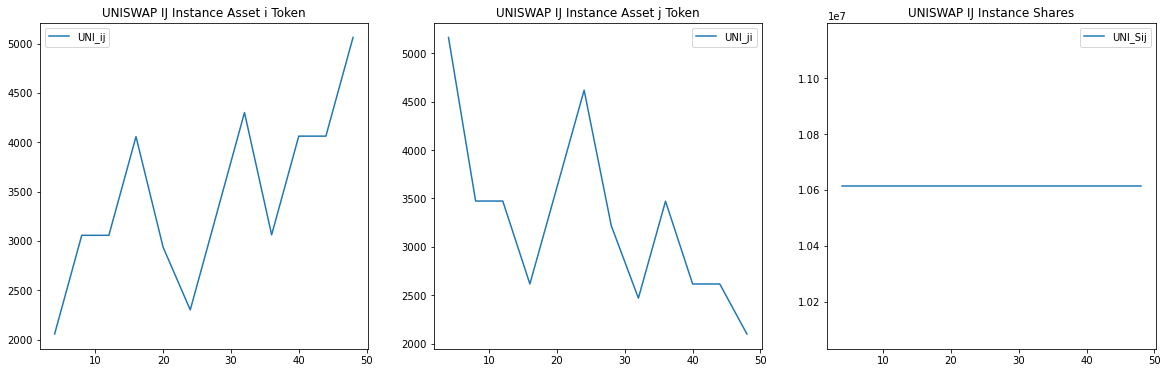

In [13]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
uniswap_ij.astype(float).plot(ax=ax, y=['UNI_ij'])
plt.title('UNISWAP IJ Instance Asset i Token')

ax = plt.subplot(132)
uniswap_ij.astype(float).plot(ax=ax, y=['UNI_ji'])
plt.title('UNISWAP IJ Instance Asset j Token')

ax = plt.subplot(133)
uniswap_ij.astype(float).plot(ax=ax, y=['UNI_Sij'])
plt.title('UNISWAP IJ Instance Shares')
plt.show()

### Prices of the i-j asset swap

The following command line creates a plot of the swap prices
- the swap price of the risk asset 
- the pool ratio price of the risk asset

Comparison of both plots shows the effects of fees.

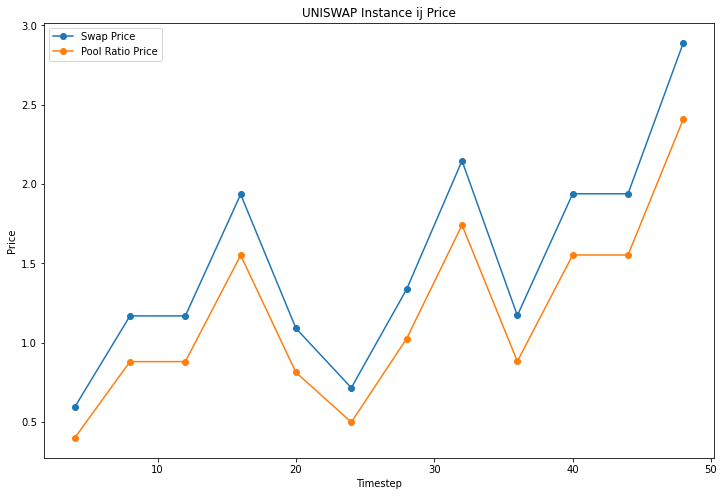

In [14]:
price_plot(rdf,'UNISWAP Instance ij Price', 'UNI_P_ij', 'UNI_ji','UNI_ij' )


## Global State Variables for Hydra instance

The Hydra system state can be described with the following global variables:

| Symbol | Name | Definition  | Domain |  | Unit | | 
| --------|------- | -------- | -------- | -------- | -------- |-------|
| $H$     | HDX Total Supply     | Supply is the total quantity of the native protocol token (HDX).|  ${\mathbb{R}_{++}}$| | HDX; an amount in real positive numbers
| $Q$     | Base Pool Liquidity     | Base Pool Liquidity is the total quantity of the base asset (HDX) inside Pool.|  ${\mathbb{R}_{+}}$| | HDX; a positive real number if a pool has at least one risk asset
| $\mathbf{\vec{R}}$ | Reserve Risk Assets     | An $n$-dimensional vector whose components are quantities of risk assets provided to the Liquidity Pool by liquidity providers.      |  $\mathbb{R}_{++}^{n}$ | | BTC, ETH, DOT,...; a vector of real positive numbers denoting quantities of each asset in the pool.
| $\mathbf{\vec{S}}$     | Asset Shares     | Asset Shares are non-normalized values of each risk asset in the pool which are minted and distributed to the liquidity providers at time of inception of their asset into the Liquidity Pool. |  $\mathbb{R}_{++}^{n}$ | | a vector of real positive numbers
| $S^Q$     | Base Pool Share     | The Pool value share of the base asset (HDX), i.e. claims on $Q$.|  $\mathbb{R}_{+}$ | | HDX; a real positive number if there exists at least one risk asset in the pool
| $\mathbf{\vec{W}}$     | Asset Weights     | Asset Weights are non-normalized values of each risk asset in the pool used in the Uniswap/Balancer mechanisms. |  $\mathbb{R}_{++}^{n}$ | | a vector of real positive numbers
| $W^Q$     | Base Pool Weight     | The non-normalized Pool value weight of the base asset (HDX).|  $\mathbb{R}_{+}$ | | a real positive number
| $\mathbf{{P}}$     | Price    | The Price is a (n+1)x(n+1) Matrix listing all spot prices for all risk assets present in the Liquidity pool. Its components $p_{i,j}$ are the prices of the i-th asset denoted in the j-th asset.| $\mathbb{R}_{++}^{n\times n}$ | | f.e: ETH/HDX; depending on the component $p_{ij}$ of the matrix the unit is currency$_i$ / currency$_j$ where for the above example $i$ is ETH and $j$ is HDX. |
| $\vec{p}^Q$     | Asset Base Price    | The Asset Base Price is a vector listing the spot prices of all risk assets in the pool in terms of the base asset HDX. | $\mathbb{R}^n_{++}$ | | A real number representing the rate of exchange between a risk asset and HDX, e.g. ETH/HDX. |


Notice that $H$, $Q$ and $S^Q$ represent the Base side of the Omnipool and are tracked separately in the Hydra World whereas the other variables representing the Risk side of the Omnipool are encoded in $\mathbf{\vec{R}}$ , $\mathbf{\vec{S}}$  are tracked by the `pool` variable

## Hydra World
### Base Asset side of the Omnipool
### Quantities of the base asset in the pool and in the system, and the base-shares

The following command lines create three plots that show: (for the base asset)
- on the left: the quantity of base asset in the pool `Hydra_Q` 
- center: the total quantity of base asset in the system `Hydra_H` 
- on the right: the quantity of base asset shares `Hydra_Sq`

over the simulation steps

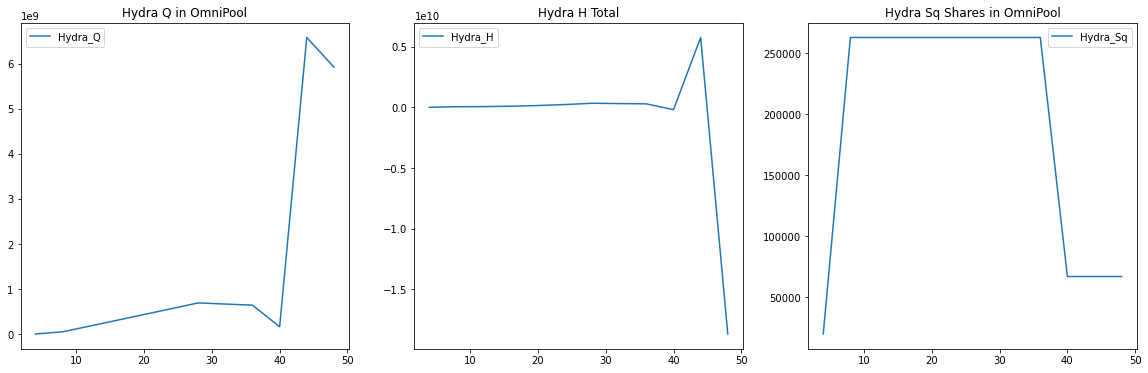

In [15]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
hydra.astype(float).plot(ax=ax, y=['Hydra_Q'])
plt.title('Hydra Q in OmniPool')

ax = plt.subplot(132) 
hydra.astype(float).plot(ax=ax, y=['Hydra_H'])
plt.title('Hydra H Total')

ax = plt.subplot(133)
hydra.astype(float).plot(ax=ax, y=['Hydra_Sq'])
plt.title('Hydra Sq Shares in OmniPool')
plt.show()

## Hydra World
### Risk Asset side of the Omnipool
### Quantities of the i-th risk asset, i-Shares and the price for i

The following command line creates three plots for the Hydra Omnipool (for the i-th asset on the risk side)

- the asset index can be set individually to `i`, `j`, etc.


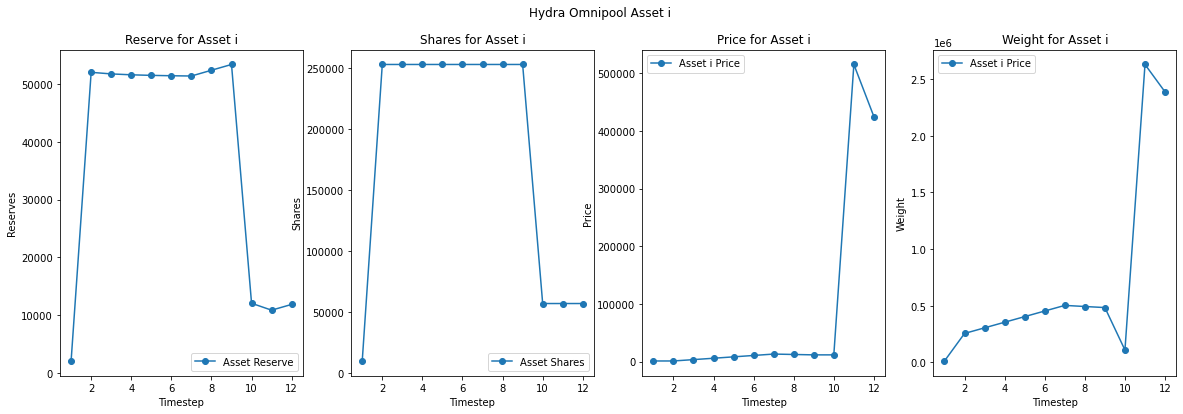

In [16]:
hydra_pool_plot(rdf,'Asset i Reserve and Shares', rdf.last_valid_index(),str('i'))

### Quantities of the j-th risk asset, j-Shares and the price for j

The following command line creates three plots for the Hydra Omnipool 

- the asset index can be set individually to `i`, `j`, etc.


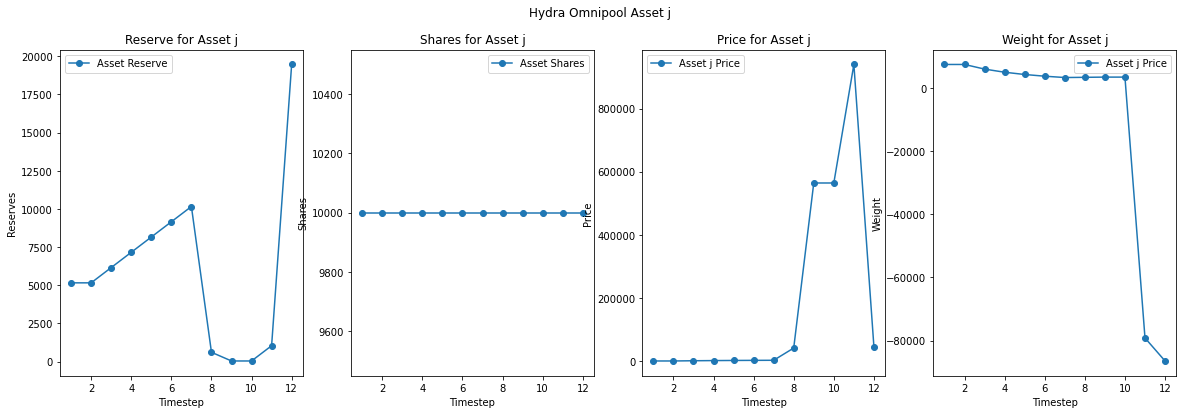

In [17]:
hydra_pool_plot(rdf,'Asset j Reserve and Shares', rdf.last_valid_index(),str('j'))

### Quantities of the k-th risk asset, k-Shares and the price for k

The following command line creates three plots for the Hydra Omnipool 

- the asset index can be set individually to `i`, `j`, etc.

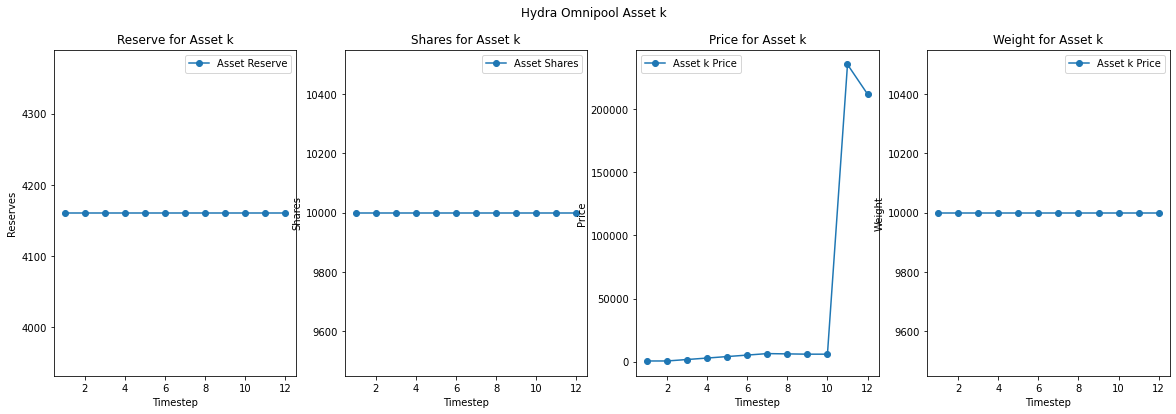

In [18]:
hydra_pool_plot(rdf,'Asset k Reserve and Shares', rdf.last_valid_index(),str('k'))

### Price comparison for assets on the risk side of the Omnipool

The following command lines create a plots for the Hydra Omnipool prices:
- Asset Base Prices
- Share to Reserve Ratio Base Prices
- Relative Asset Prices `i` to `j`
- Relative Asset Prices `i` to `k`
- Relative Asset Prices `j` to `k`

    

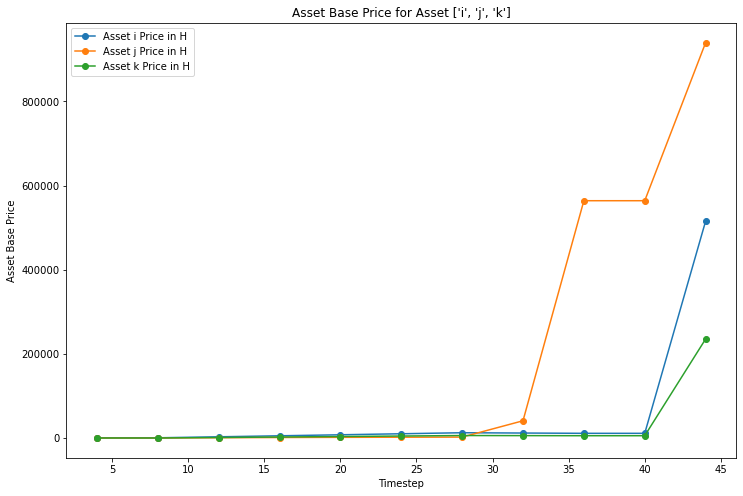

In [19]:
hydra_pool_price_plot(rdf,'Asset Base Price', rdf.last_valid_index(),['i', 'j','k'])

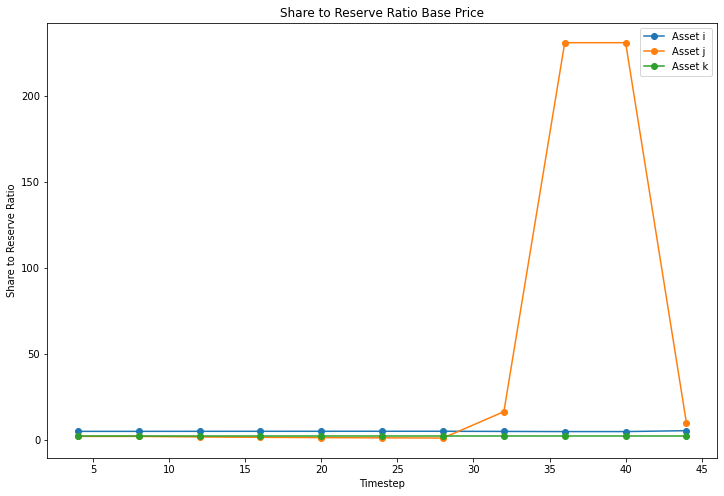

In [20]:
trade_liq_plot(rdf,'Share to Reserve Ratio Base Price', rdf.last_valid_index(),['i', 'j','k'])

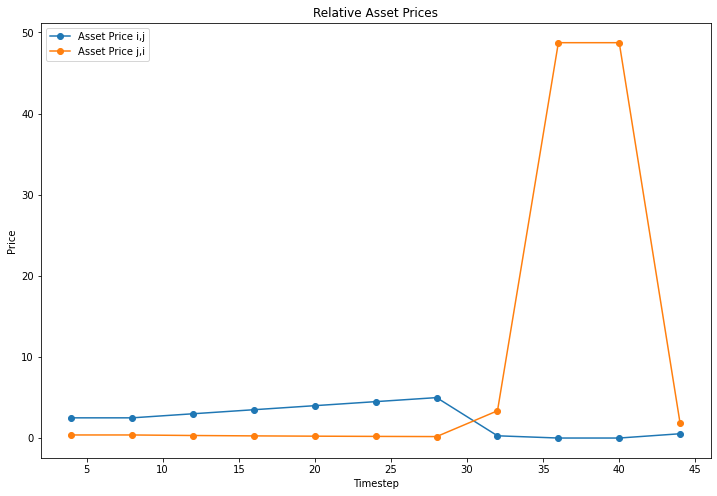

In [21]:
rel_price_plot(rdf,'Relative Asset Prices', rdf.last_valid_index(),['i', 'j'])

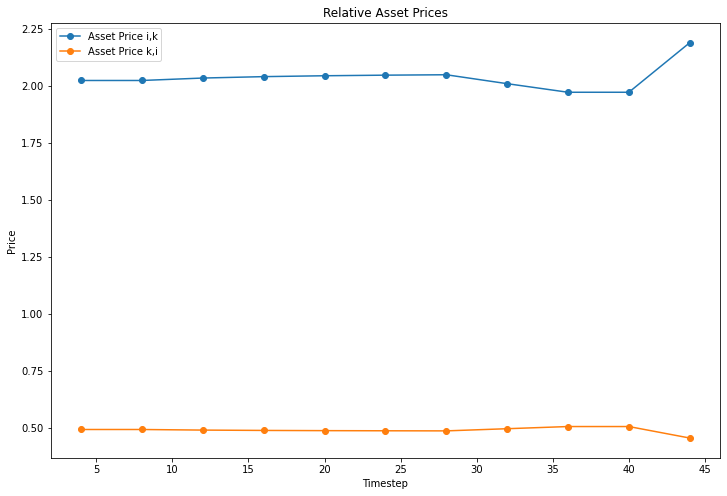

In [22]:
rel_price_plot(rdf,'Relative Asset Prices', rdf.last_valid_index(),['i', 'k'])

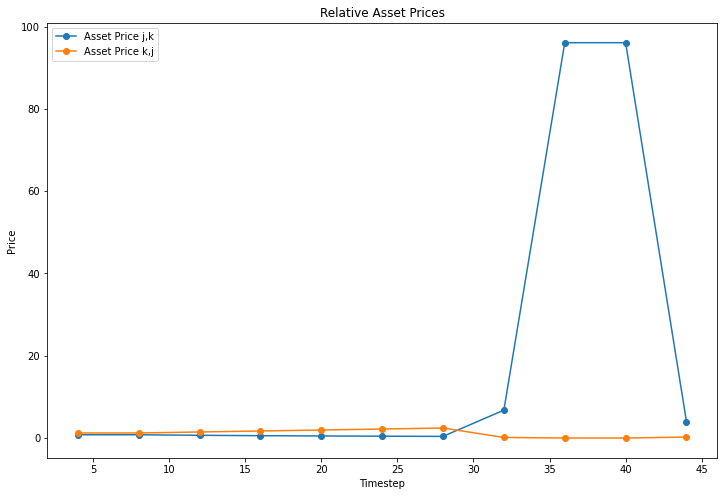

In [23]:
rel_price_plot(rdf,'Relative Asset Prices', rdf.last_valid_index(),['j', 'k'])


# Agents and their Local State Variables

The following section tracks the development for the agent states.
As every agent is defined to be responsible for a different action and all agent states are shown this section can be used to assess 
- the intentional changes in the local states directly affected by the actions, and
- the unintentional changes in local states of other agents who are indirectly affected

All agents carry the following local states:

| Symbol | Name | Definition  | Domain |   | Unit
| -------- | -------- | -------- | -------- | -------- | --------|
| $\mathbf{r}^j$     | Reserve Assets     | Reserve Assets are quantities of privately held risk assets by liquidity provider agent $j$ which are not (yet) related to the Liquidity Pool. |  $\mathbb{R}_{+}^{n}$| | BTC, ETH, DOT,...; an amount in real non-negative numbers denoted in the respective currency unit
| $h^j$     | Base Asset     | Total Base Asset (HDX) amount of $H$ held by agent $j$. |  $\mathbb{R}_{+}$| | a real non-negative amount of HDX |
| $\mathbf{s}^j$     | Risk Asset Shares     | Risk Asset Share as value of liquidity provider agent $j$'s contribution of risk asset(s) to the Liquidity Pool, minted and distributed (as a claim) to agent $j$ at the time of introduction into the Pool.| $\mathbb{R}_{+}^{n}$  | |a vector of amounts in real non-negative numbers
| $s^{qj}$     | Base Asset Share     | Base Asset (HDX) share as value of liquidity provider agent $j$'s contribution of HDX to the Liquidity Pool,  minted and distributed to agent $j$ (as a claim) at the time of introduction into the Pool.| $\mathbb{R}_{+}$  | |a real non-negative number

To locate specific values in the dataframe the commands
- `first_valid_index()`
- `first_valid_index()*x`
- `last_valid_index()`

can be used.


## Hydra World

Results for the copy of the agents going through the Hydra world are saved in `hydra_agents`


In [24]:
rdf['hydra_agents'][rdf.first_valid_index()]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
1,1,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
2,2,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
3,3,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
4,4,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
5,5,100988,108000,140000,170000,150000,0,118000,130988,180000,160000
6,6,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
7,7,100000,110000,140000,170000,150000,0,120000,130000,180000,160000


In [25]:
rdf['hydra_agents'][rdf.first_valid_index()*10]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
1,1,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
2,2,91366,118633,140000,170000,197105,0,120000,130000,180000,160000
3,3,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
4,4,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
5,5,99624,113117,140000,170000,150000,0,123117,129624,180000,160000
6,6,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
7,7,100000,110000,140000,170000,150000,0,120000,130000,180000,160000


## Uniswap world

Results for the copy of the agents going through the Hydra world are saved in `uni_agents`

In [26]:
rdf['uni_agents'][rdf.first_valid_index()]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
1,1,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
2,2,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
3,3,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
4,4,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
5,5,100494,109000,140000,170000,150000,0,119000,130494,180000,160000
6,6,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
7,7,100000,110000,140000,170000,150000,0,120000,130000,180000,160000


In [27]:
rdf['uni_agents'][rdf.first_valid_index()*7]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
1,1,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
2,2,50000,160000,140000,170000,346001,0,120000,130000,180000,160000
3,3,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
4,4,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
5,5,99250,110942,140000,170000,150000,0,120942,129250,180000,160000
6,6,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
7,7,100000,110000,140000,170000,150000,0,120000,130000,180000,160000


In [28]:
rdf['uni_agents'][rdf.first_valid_index()*12]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
1,1,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
2,2,99999,110001,140000,170000,150000,0,120000,130000,180000,160000
3,3,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
4,4,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
5,5,97489,112060,140000,170000,150000,0,122060,127489,180000,160000
6,6,100000,110000,140000,170000,150000,0,120000,130000,180000,160000
7,7,100000,110000,140000,170000,150000,0,120000,130000,180000,160000


## Agent Token Holdings - Uniswap World


The following command line creates eight plots, one for each agent individually, showing his token holdings 


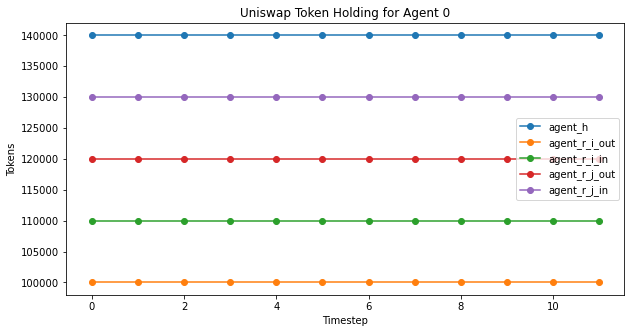

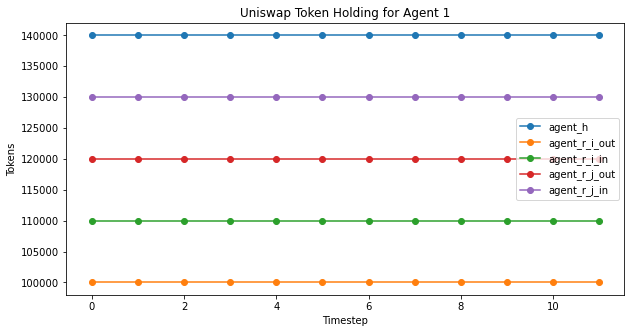

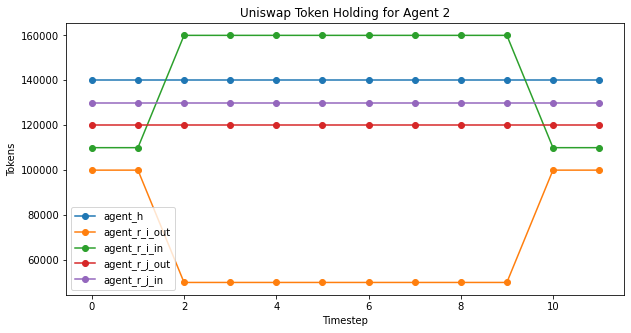

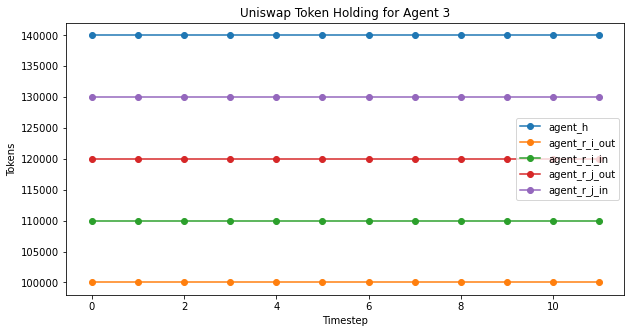

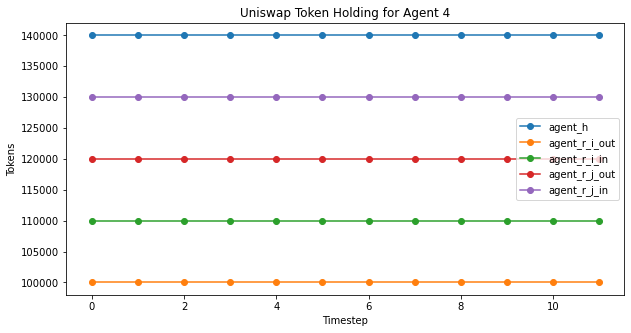

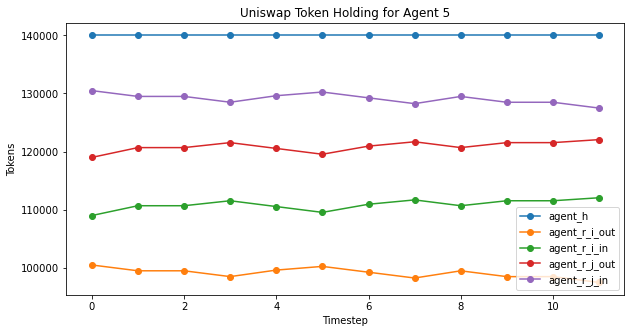

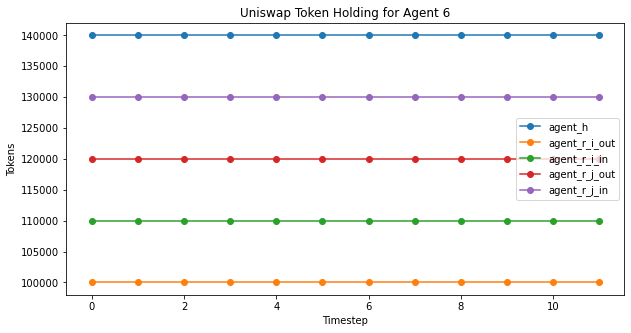

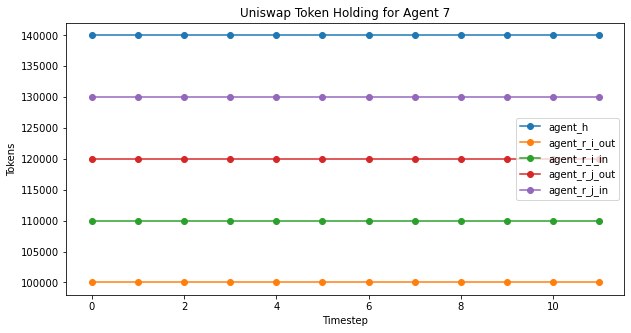

In [29]:
agent_plot(rdf,'Uniswap Token Holding for Agent ', len(rdf['timestep'])) #,4,'j')

## Agent Values - Uniswap World

The following command line creates eight plots, one for each agents showing his values. These are the token holdings multiplied by price.
  



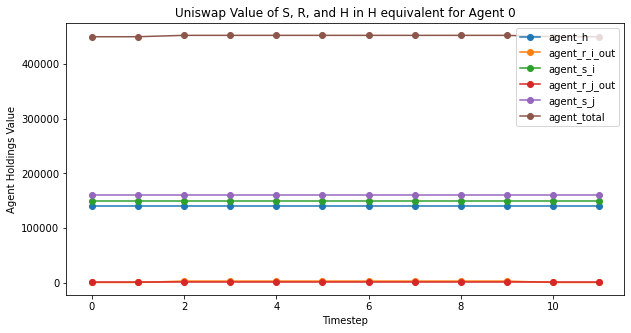

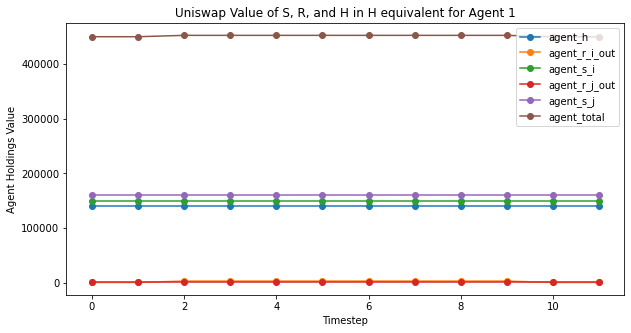

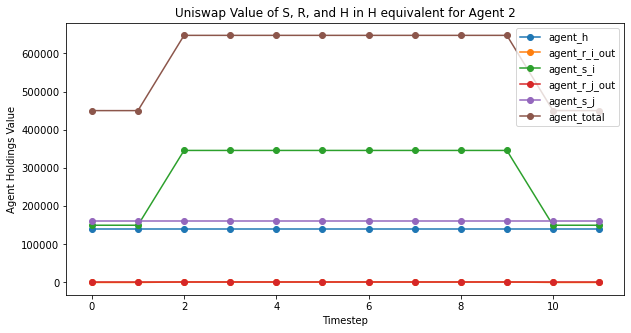

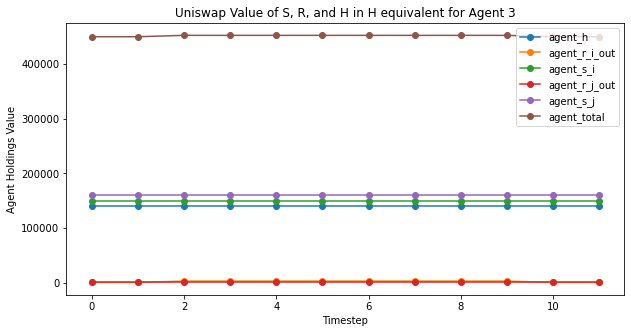

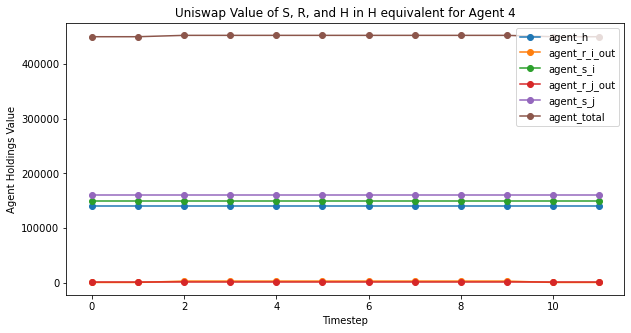

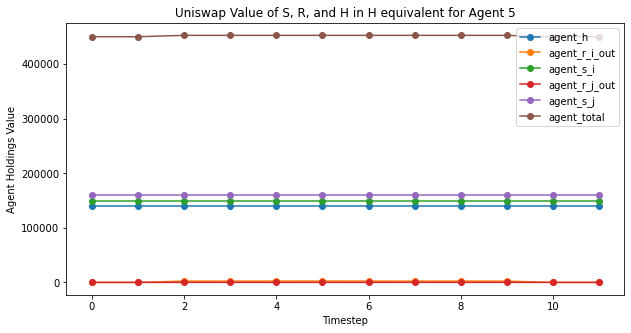

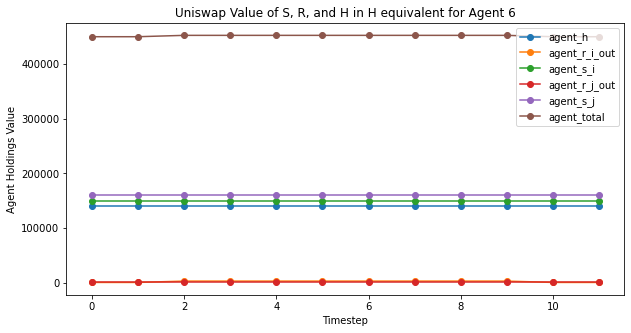

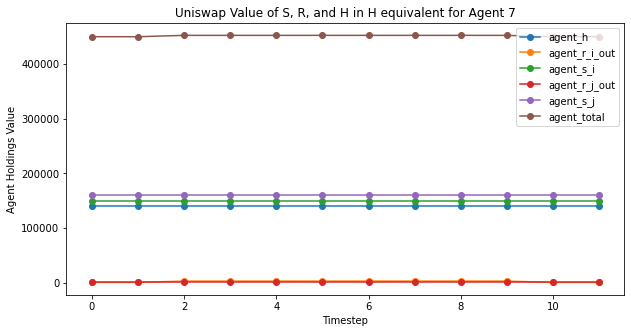

In [30]:
agent_value_plot(rdf,'Uniswap Value of S, R, and H in H equivalent', len(rdf['timestep'])) #,2, 'i')

## Agent Token Holdings - Hydra World

The following command line creates eight plots, one for each agents indivudially, showing his token holdings


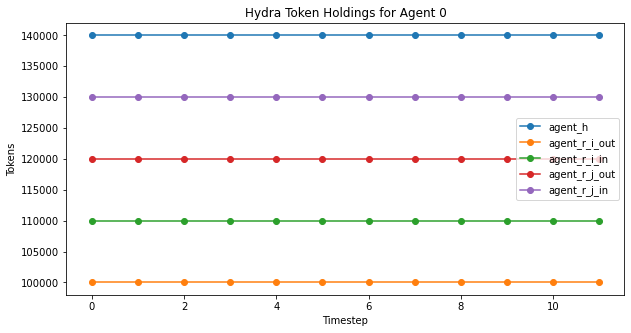

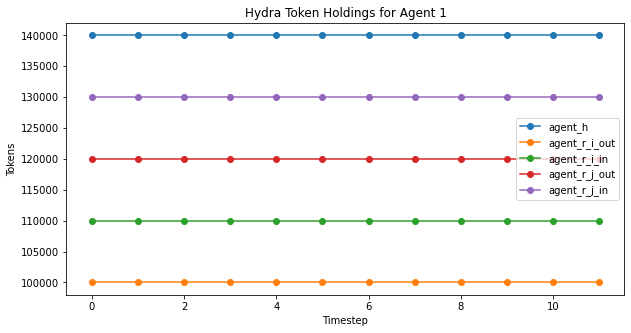

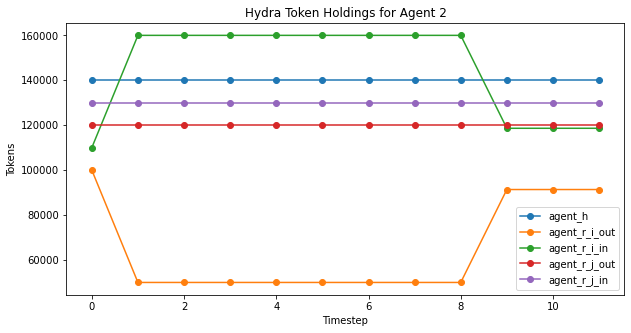

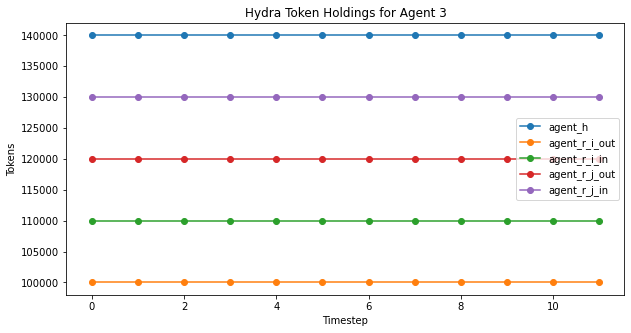

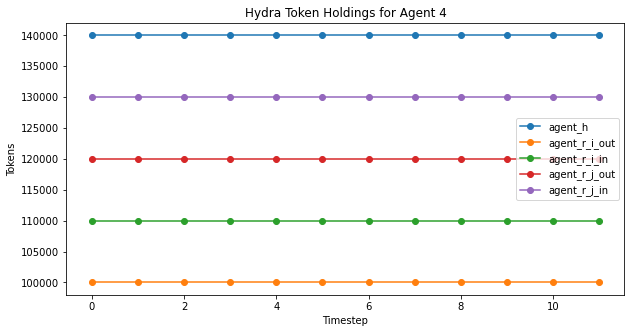

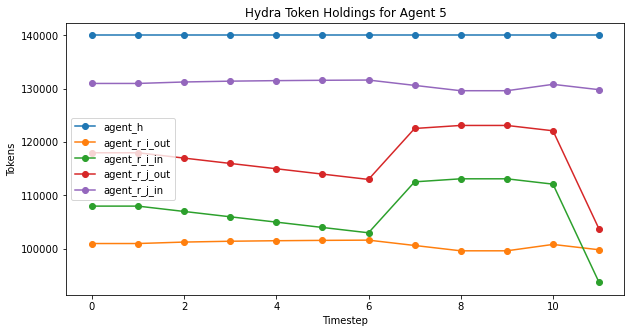

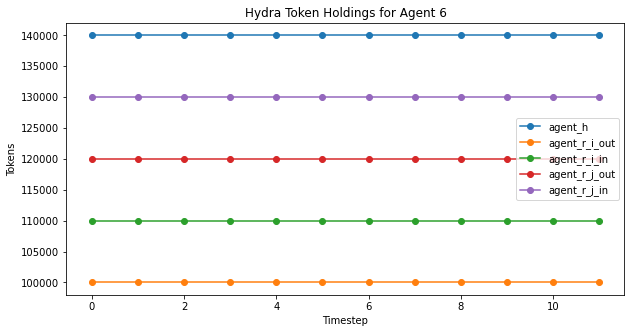

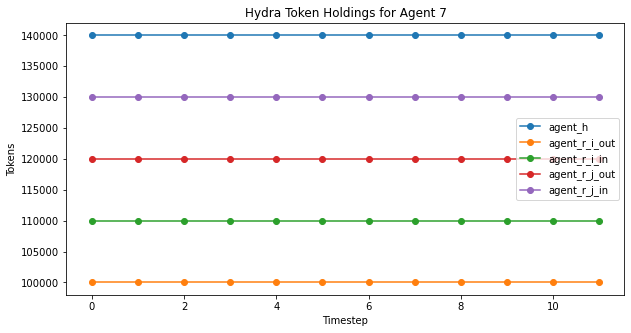

In [31]:
hydra_agent_plot(rdf,'Hydra Token Holdings for Agent ', len(rdf['timestep']))

## Agent Values - Hydra World

The following command line creates eight plots, one for each agents showing his values. These are the token holdings multiplied by price.


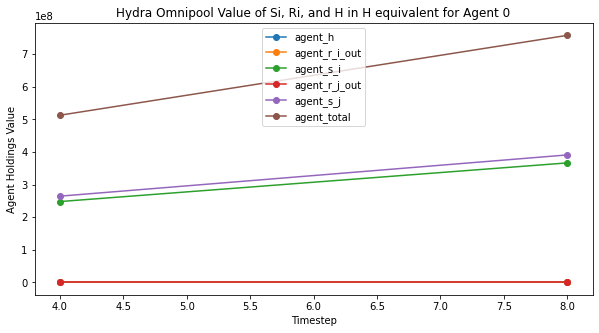

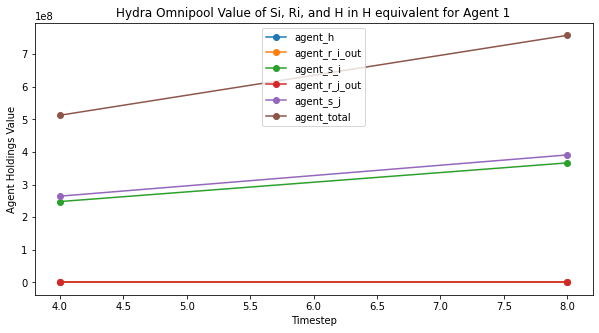

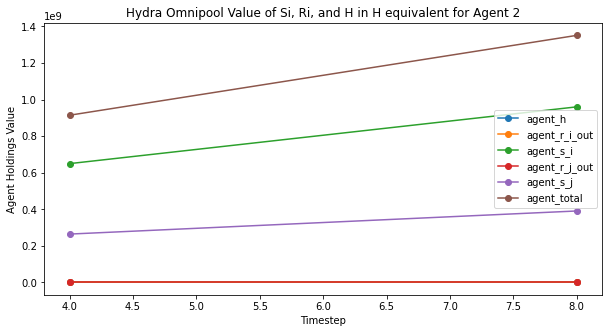

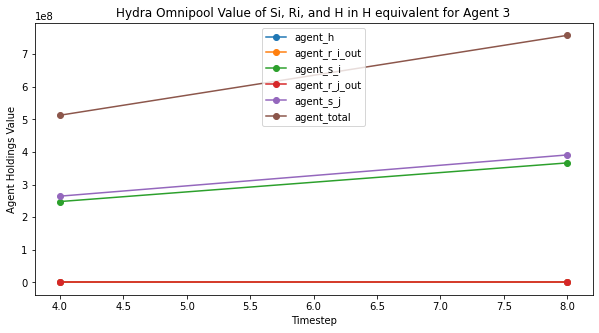

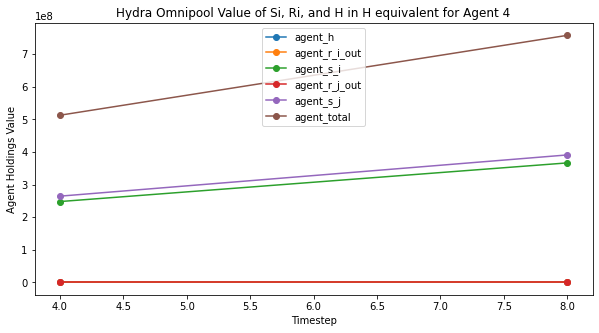

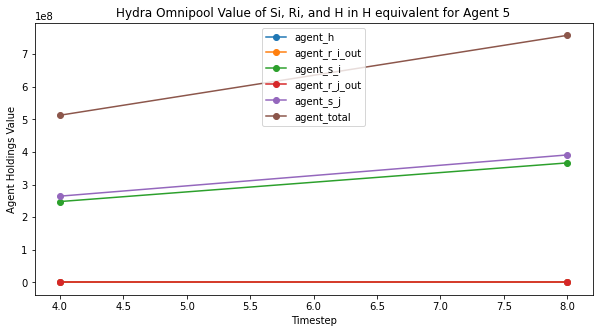

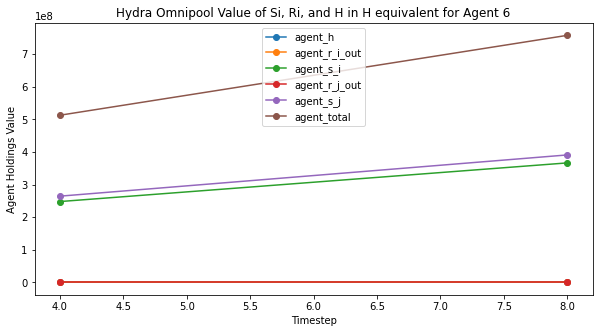

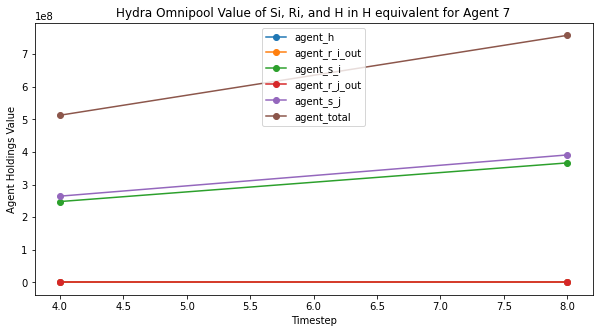

In [32]:
hydra_agent_value_plot(rdf,'Hydra Omnipool Value of Si, Ri, and H in H equivalent', len(rdf['timestep'])) #,2, 'i')

### Impermanent Loss (IL) calculation

Impermanent loss is defined as 

$$
IL = \frac{\delta Pool Value}{\delta Hold Value} - 1
$$


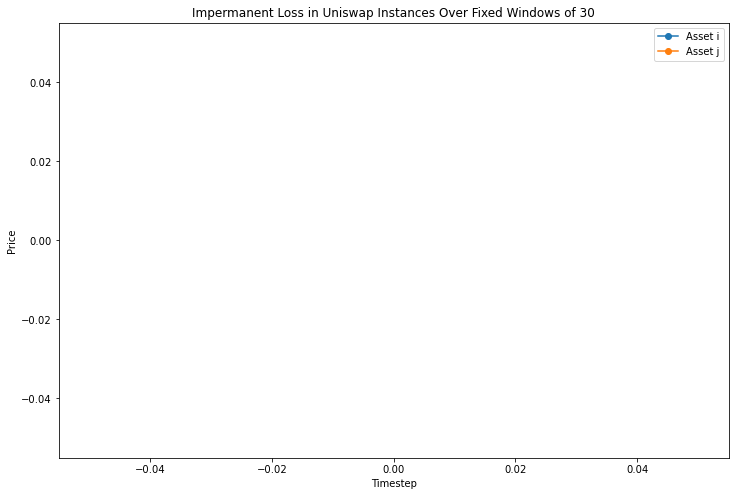

In [33]:
IL_plot(rdf,'Impermanent Loss in Uniswap Instances Over Fixed Windows of ', 30)